In [13]:
import numpy as np 
import os
import shutil
import json
import glob
import cv2 as cv2
import torch
import tifffile as tf
from torch import nn
from typing import List, Tuple, Dict
from detectron2.config import get_cfg
from ubteacher.config import add_ubteacher_config
from ubteacher.modeling.meta_arch.rcnn import TwoStagePseudoLabGeneralizedRCNN # required to load model
from detectron2.engine import DefaultPredictor
from detectron2.checkpoint import DetectionCheckpointer
from ubteacher.modeling.meta_arch.ts_ensemble import EnsembleTSModel
from ubteacher.engine.trainer import UBRCNNTeacherTrainer
from detectron2.utils.visualizer import Visualizer


from histomicstk.saliency.tissue_detection import get_tissue_mask
from histomicstk.preprocessing.color_normalization import reinhard
from matplotlib.colors import ListedColormap
from skimage.morphology import binary_closing
from scipy.ndimage import binary_fill_holes, binary_dilation
from skimage.segmentation import watershed

from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from detectron2.evaluation import DatasetEvaluator
from collections import defaultdict
import numpy as np


In [14]:
def get_conv_layers(model: object) -> List:
    backbone_conv_layers = []
    for layer_name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) and "backbone" in layer_name:
            backbone_conv_layers.append(layer_name)
    return backbone_conv_layers


class GradCAM_multilayer:
    def __init__(self, model:object, input_image: np.ndarray, target_layers: List):
        self.model = model
        self.input_image = input_image
        self.gradients = []
        self.activations = []
        self.handles = []
        self.target_layers = target_layers
        self._register_hook()
    
    def _save_activation(self, module, input, output):
        #print(f"activations: {output[0].shape}")
        self.activations.append(output.detach().cpu())

    def _save_gradient(self, module, input, output):
        # Gradients are computed in reverse
        def _store_grad(grad):
            #print(f"gradients: {grad[0].shape}")
            self.gradients = [grad.detach().cpu()] + self.gradients
        self.handles.append(
            output.register_hook(_store_grad)
        )

    def _register_hook(self):
        for (layer_name, module) in self.model.named_modules():
            for i in self.target_layers:
                if layer_name == i:
                    self.handles.append(
                        module.register_forward_hook(self._save_activation)
                    )
                    self.handles.append(
                        module.register_forward_hook(self._save_gradient)
                    )
    
    def release(self):
        for handle in self.handles:
            handle.remove()

    def compute_cam_per_layer(self):
        activations_list = [a[0].data.numpy() for a in self.activations]
        grads_list = [g[0].data.numpy() for g in self.gradients]
        cam_per_target_layer = []
        
        for i in range(len(self.target_layers)):
            layer_activations = None
            layer_grads = None
            if i < len(activations_list):
                layer_activations = activations_list[i]
            if i < len(grads_list):
                layer_grads = grads_list[i]
            #print(f"layer_grads: {layer_grads.shape}")
            layer_weights = np.mean(layer_grads, axis=(1, 2))
            #print(f"layer_weights: {layer_weights.shape}")
            #print(f"layer activations: {layer_activations.shape}")
            weighted_activations = layer_activations * layer_weights[:, np.newaxis, np.newaxis]
            layer_cam = np.sum(weighted_activations, axis=0)  # [H,W]
            #print(f"layer_cam b4 postprocessing: {layer_cam.shape}")
            # Postprocess
            layer_cam = np.maximum(layer_cam, 0)  # ReLU
            layer_cam -= np.min(layer_cam)
            layer_cam /= np.max(layer_cam)
            # Resize to input image
            resized_layer_cam = cv2.resize(layer_cam, (self.input_image.shape[1], self.input_image.shape[0]))
            # Append to list
            cam_per_target_layer.append(resized_layer_cam)
        return cam_per_target_layer
    
    def get_cam(self):
        cams = self.compute_cam_per_layer()
        # Stack cams from all requested layers together
        cams = np.stack(cams, axis=0)
        #print(f"after concatenating: {cams.shape}")
        # Combine all cams and normalize
        combined_cam = np.maximum(cams, 0)
        combined_cam = np.mean(cams, axis=0)
        #print(f"final cam: {final_cam.shape}")
        combined_cam -= np.min(combined_cam)
        combined_cam /= np.max(combined_cam)
        return combined_cam

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        self.release()
    
class GenerateCam:
    def __init__(self, model: object, inputs: Dict, input_image, target_class: int, target_layers: List) -> None:
        self.model = model
        self.inputs = inputs
        self.input_image = input_image
        self.target_class = target_class
        self.target_layers = target_layers

    def generate_cam(self):
        grad_cam = GradCAM_multilayer(
            self.model,
            self.input_image,
            self.target_layers)
        with grad_cam as cam:
            model = self.model
            model.eval()
            predictions = model.inference(self.inputs)[0]
            pred_classes = predictions['instances'].pred_classes.detach().cpu()
            scores = predictions['instances'].scores
            class_scores = []
            for scr, cls in zip(scores, pred_classes):
                if cls == self.target_class:
                    class_scores.append(scr)
            top_score = torch.max(torch.stack(class_scores))
            top_score.backward(retain_graph=True)
            raw_cam = cam.get_cam()
            
        return raw_cam

    def visualize_cam(self, raw_cam: np.ndarray) -> np.ndarray:
        """ Generate heatmap from cam and resize it to input size
        Args:
        raw_cam: [H, W]
        """
        heatmap = cv2.applyColorMap(np.uint8(255 * raw_cam), cv2.COLORMAP_JET)
        heatmap = cv2.cv2tColor(heatmap, cv2.COLOR_BGR2RGB)
        cam = 0.5*heatmap + 0.5*self.input_image
        cam -= np.max(np.min(cam), 0)
        cam /= np.max(cam)
        return cam

    def __call__(self) -> np.ndarray:
        raw_cam = self.generate_cam()
        final_cam = self.visualize_cam(raw_cam)
        return final_cam

In [ ]:
def get_thumbnail(image_file, max_dim=2560):
    with tf.TiffFile(image_file) as slide:
        # Get image thumbnail
        image_thumbnail = slide.pages[2].asarray()
    return image_thumbnail

In [ ]:
class ParseUnlabeled:
    def __init__(self, u_img_dir):
        self.u_img_dir = u_img_dir
        
    def get_unlabeled_coco(self, img_file):
            
            """
            Get unlabeled coco format for detectron2
            """
            f = np.load(img_file)
            shape = f.shape
            del f # use del instead of with because numpy version issue
            img_base = os.path.basename(os.path.splitext(img_file)[0])
                       
            ## Fill remaining fields
            
            dataset_dicts = [{'file_name': img_file,
                            'height': shape[0],
                            'width': shape[1],
                            'image_id': img_base}
                            ]  
    
            return dataset_dicts 
        
def custom_visualizer(img_id, 
                      img, 
                      instances, 
                      color='r',
                      threshold = 0.7,
                      gt_instances = None, 
                      merged_bboxes = False, 
                      cat_map = None):
    """
    Custom visualizer for UBTeacher2 inference.
    """
    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(img)
    
    # Loop over instances and draw boxes
    if merged_bboxes:
        for i in range(len(instances)):
            if instances[i]['score'] > threshold:
                x1, y1, x2, y2 = instances[i]['bbox']
                w = x2 - x1
                h = y2 - y1
                rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)
    else:
        for i in range(len(instances)):
            if cat_map:
                cat = cat_map[str(instances[i].pred_classes.numpy()[0])]
            else:
                cat = instances[i]['category_id']
            score = float(instances[i]['score'])
            if score > threshold:
                x1, y1, x2, y2 = instances[i]['bbox']
                w = x2 - x1
                h = y2 - y1
                rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor=color,facecolor='none')
                ax.add_patch(rect)
                #ax.text(x1, y1, cat, fontsize=9, color='r')
                #ax.text(x1, y1, str(round(instances[i]['score'], 2)), fontsize=11, color='g')
    # Loop over ground truth instances and draw boxes
    if gt_instances is not None:
        for i in range(len(gt_instances[img_id])):
            if cat_map:
                gt_cat = cat_map[str(gt_instances[img_id][i]['category_id'])]
            else:
                gt_cat = gt_instances[img_id][i]['category_id']
            box = gt_instances[img_id][i]['bbox']
            x1, y1, x2, y2 = box
            gt_rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor=color,facecolor='none')
            ax.add_patch(gt_rect)
            #ax.text(x1, y1, gt_cat, fontsize=9, color='g')
            try:
                gt_poly = gt_instances[img_id][i]['segmentation']
                gt_poly = np.array(gt_poly).reshape((int(len(gt_poly)/2), 2))
                ax.fill(gt_poly[:, 0], gt_poly[:, 1], alpha=0.5, color='g')
            except:
                print("No segmentation for ground truth annotation.")
                pass
    return fig, ax

def detectron2_visualizer(img, outputs):
    v = Visualizer(img[:, :, ::-1], scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return v.get_image()[:, :, ::-1]

def comparison_visualizer(img, annos1, annos2, threshold=0.7):
    """
    Custom visualizer for comparing two sets of annotations.
    """
    # Create figure and axes
    fig,ax = plt.subplots(1, figsize=(15,15))
    # Display the image
    ax.imshow(img)
    
    # Loop over instances and draw boxes
    for i in range(len(annos1)):
        score = float(annos1[i]['score'])
        if score > threshold:
            x1, y1, x2, y2 = annos1[i]['bbox']
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor='y',facecolor='y', alpha=0.35)
            ax.add_patch(rect)
    for i in range(len(annos2)):
        score = float(annos2[i]['score'])
        if score > threshold:
            x1, y1, x2, y2 = annos2[i]['bbox']
            w = x2 - x1
            h = y2 - y1
            rect = patches.Rectangle((x1,y1),w,h,linewidth=1,edgecolor='b',facecolor='b', alpha=0.25)
            ax.add_patch(rect)
    return fig, ax

def merge_bboxes(self, boxes: list, iou_thresh: int=0) -> list:
        """Merge overlapping bounding boxes.
        Args:
        boxes -- list of boxes with format [x, y, w, h]
        iou_thresh -- threshold for IOU to trigger merging
        Return:
        a list of merged boxes without overlap
        """
        box_arr1 = self.sort_boxes(boxes)
        if len(box_arr1) == 0:
            return box_arr1
        box_arr2 = [box_arr1.pop(0)]
        while len(box_arr1) > 0:
            merge = False
            # Assign left box as A, right as B
            keys = ['x1', 'y1', 'x2', 'y2']
            remove_indices = []
            for n in range(len(box_arr1)):
                ref_box = box_arr2[-1]  # Use the last box in arr2 as reference
                boxes2compare = []
                for box in (ref_box, box_arr1[n]):
                    x, y, w, h = box
                    boxes2compare.append(int(i) for i in [x, y, x+w, y+h])
                A = dict(zip(keys, boxes2compare[0]))
                B = dict(zip(keys, boxes2compare[1]))
                # Check if there's no overlap b/w these two boxes
                if B['x1'] > A['x2'] or \
                    max(A['y1'], B['y1']) > min(A['y2'], B['y2']):
                    continue
                else:
                    # Calculate IOU
                    u_w = max(A['x2'], B['x2']) - min(A['x1'], B['x1'])
                    u_h = max(A['y2'], B['y2']) - min(A['y1'], B['y1'])
                    union = u_w * u_h
                    i_w = min(A['x2'], B['x2']) - B['x1']
                    i_h = min(A['y2'], B['y2']) - max(A['y1'], B['y1'])
                    intersect = i_w * i_h
                    iou = (intersect / union) * 100
                    if iou >= iou_thresh:
                        # Merge boxes
                        merge = True
                        remove_indices.append(n)
                        merged_box = [A['x1'], min(A['y1'], B['y1']), u_w, u_h]
                        box_arr2.pop(-1)
                        box_arr2.append(merged_box)
                        # Look back
                        box_arr2 = self.merge_bboxes(box_arr2)
            # After looping through box_arr1, remove boxes that have been merged
            # or exhaustively compared from box_arr1
            box_arr1 = [i for n, i in enumerate(box_arr1) if n not in remove_indices]
            if not merge:  # If no merging event has occured
                # Add the 1st box from box_arr1 to box_arr2 for the next round
                box_arr2.append(box_arr1.pop(0))
        return box_arr2

def pad_image(img: np.ndarray, padding: float):
    """Helper function to pad a binary image
    Args:
    img -- input image with shappe (h, w)
    pad -- fraction of input image to pad
    """
    #print(img.shape)
    h_pad = int((img.shape[0]*padding)//2)
    w_pad = int((img.shape[1]*padding)//2)
    #print(h_pad, w_pad)
    #print(type(h_pad), type(w_pad))
    padded = np.copy(np.pad(
        img, 
        ((h_pad, h_pad), (w_pad, w_pad)),
        mode='constant', 
        constant_values=1))
    return padded

### Single Image Testing

In [21]:
vals = np.random.rand(256,3)
vals[0, ...] = [0.9, 0.9, 0.9]
cMap = ListedColormap(1 - vals)

image_file = '/mnt/RSX/Datasets_pathology/SRI_OSCC_lymph_unlabeled/Case 27 F4.svs'

f, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(thumbnail)
ax[1].imshow(labeled, cmap=cMap) # all tissue regions
plt.show()
plt.close()



NameError: name 'labeled' is not defined

Error in callback <function _draw_all_if_interactive at 0x7f0b1e874280> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [7]:
dilated_img = binary_fill_holes(labeled)
more_dilated = binary_dilation(dilated_img)
plt.imshow(more_dilated)
plt.show()
plt.close()

NameError: name 'labeled' is not defined

In [20]:
dilated_scaled = cv2.resize(more_dilated.astype(np.uint8), (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)

In [21]:
# Use mask to zero out non-tissue regions

tissue_regions = np.zeros_like(thumbnail)
for i in range(3):
    tissue_regions[:,:,i] = thumbnail[:,:,i] * dilated_scaled
plt.imshow(tissue_regions)
plt.close()

# Overlay mask contours for coloring

In [22]:
# Generate mask by thresholding and morphological transformations
kernel = (3, 3)
gray = cv2.cv2tColor(thumbnail, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, kernel, cv2.BORDER_DEFAULT)
_, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
morph = cv2.dilate(otsu, kernel, iterations=2)
morph = cv2.erode(morph, kernel, iterations=2)

# Fill small holes
# NOTE: floodfill tends to be unreliable, should skip
h, w = morph.shape
floodfill = morph.copy()
floodfill_mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(floodfill, floodfill_mask, (0, 0), 155)

# Remove small blobs and get tissue mask
# 1. Get contours
contours, hierarchy = cv2.findContours(
                        floodfill,
                        mode=cv2.RETR_TREE,
                        method=cv2.CHAIN_APPROX_SIMPLE)
# 2. Filter out contours that are too small
#    i.e., likely not tissue
cons_to_keep = []
im_area = floodfill.shape[0] * floodfill.shape[1]
for c in contours:
    cbox = cv2.boundingRect(c)
    x, y, w, h = cbox
    # Filter out boxes with weird ratios
    long_edge = max(w, h)
    short_edge = min(w, h)
    if long_edge/short_edge > 10:
        continue
    cbox_area = w * h
    if im_area*0.99 > cbox_area > im_area*0.001:
        cons_to_keep.append(c)

# Convert contours to tissue mask
final_mask = np.zeros(floodfill.shape, np.uint8)
for idx in cons_to_keep:    
    cv2.drawContours(
        final_mask,
        cons_to_keep,
        contourIdx=-1,
        color=(255),
        thickness=-1
        )
final_mask = final_mask/255

# Use mask to zero out non-tissue regions

tissue_regions2 = np.zeros_like(thumbnail)
for i in range(3):
    tissue_regions2[:,:,i] = thumbnail[:,:,i] * final_mask
plt.imshow(tissue_regions2)
plt.close()

In [23]:

#Amgad et al 2019
cnorm = {
    'mu': np.array([8.74108109, -0.12440419,  0.0444982]),
    'sigma': np.array([0.6135447, 0.10989545, 0.0286032]),
}

rgb_norm = reinhard(tissue_regions, target_mu=cnorm['mu'], target_sigma=cnorm['sigma'])
          
plt.imshow(rgb_norm)                                   
plt.close()

In [24]:
model_path = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/TissueFinderV2.2/model_final.pth'
config_path = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/TissueFinderV2.2/config.yaml'
threshold = 0.4

cfg = get_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold


student_model = UBRCNNTeacherTrainer.build_model(cfg)
teacher_model = UBRCNNTeacherTrainer.build_model(cfg)
model = EnsembleTSModel(teacher_model, student_model)
model.eval()
used_model = model.modelStudent

checkpointer = DetectionCheckpointer(model) 
checkpointer.load(cfg.MODEL.WEIGHTS)   

{'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[-5.1123e-05]],
    
             [[-2.1173e-04]],
    
             [[-7.0882e-05]],
    
             ...,
    
             [[-1.3961e-04]],
    
             [[-2.3396e-04]],
    
             [[-2.6489e-04]]],
    
    
            [[[ 7.7679e-05]],
    
             [[ 6.9109e-05]],
    
             [[ 5.0820e-05]],
    
             ...,
    
             [[ 1.3114e-04]],
    
             [[ 1.7051e-04]],
    
             [[ 2.9816e-04]]],
    
    
            [[[-1.0684e-04]],
    
             [[-1.5024e-04]],
    
             [[-2.1422e-04]],
    
             ...,
    
             [[-2.7700e-04]],
    
             [[-2.3963e-04]],
    
             [[-2.4118e-04]]],
    
    
            ...,
    
    
            [[[-3.7724e-04]],
    
             [[-3.3275e-05]],
    
             [[-3.2965e-04]],
    
             ...,
    
             [[-4.5551e-04]],
    
             [[-6.1589e-04]],
    
             [

In [28]:
## Run Model


dicty = ParseUnlabeled(im_path).get_unlabeled_coco(im_path)
#img = np.load(dict[0]['file_name'])
img = tissue_regions2
im = torch.from_numpy(img).permute(2, 0, 1)
img_id = dict[0]['file_name'].split('/')[-1].split('.')[0]
inputs = [{"image": im, "height": im.shape[1], "width": im.shape[2]}]


with torch.no_grad():
    outputs = used_model(inputs)
    instances = outputs[0]["instances"].to("cpu")
    instance_dicts = []
    for i in range(len(instances)):
        instance_dicts.append({'category_id': instances[i].pred_classes.numpy()[0], 
                                'bbox': instances[i].pred_boxes.tensor.numpy()[0].tolist(),
                                'score': instances[i].scores.numpy()[0]})
        
print(instance_dicts)

[{'category_id': 0, 'bbox': [1212.408447265625, 122.988525390625, 2198.62353515625, 1381.25537109375], 'score': 0.6669593}, {'category_id': 2, 'bbox': [636.7801513671875, 1386.4586181640625, 768.7373657226562, 1531.062744140625], 'score': 0.65584874}, {'category_id': 2, 'bbox': [69.87466430664062, 425.6307373046875, 962.7548217773438, 1529.8441162109375], 'score': 0.6289833}, {'category_id': 0, 'bbox': [88.18878173828125, 600.5092163085938, 785.0858154296875, 1520.0025634765625], 'score': 0.43451643}]


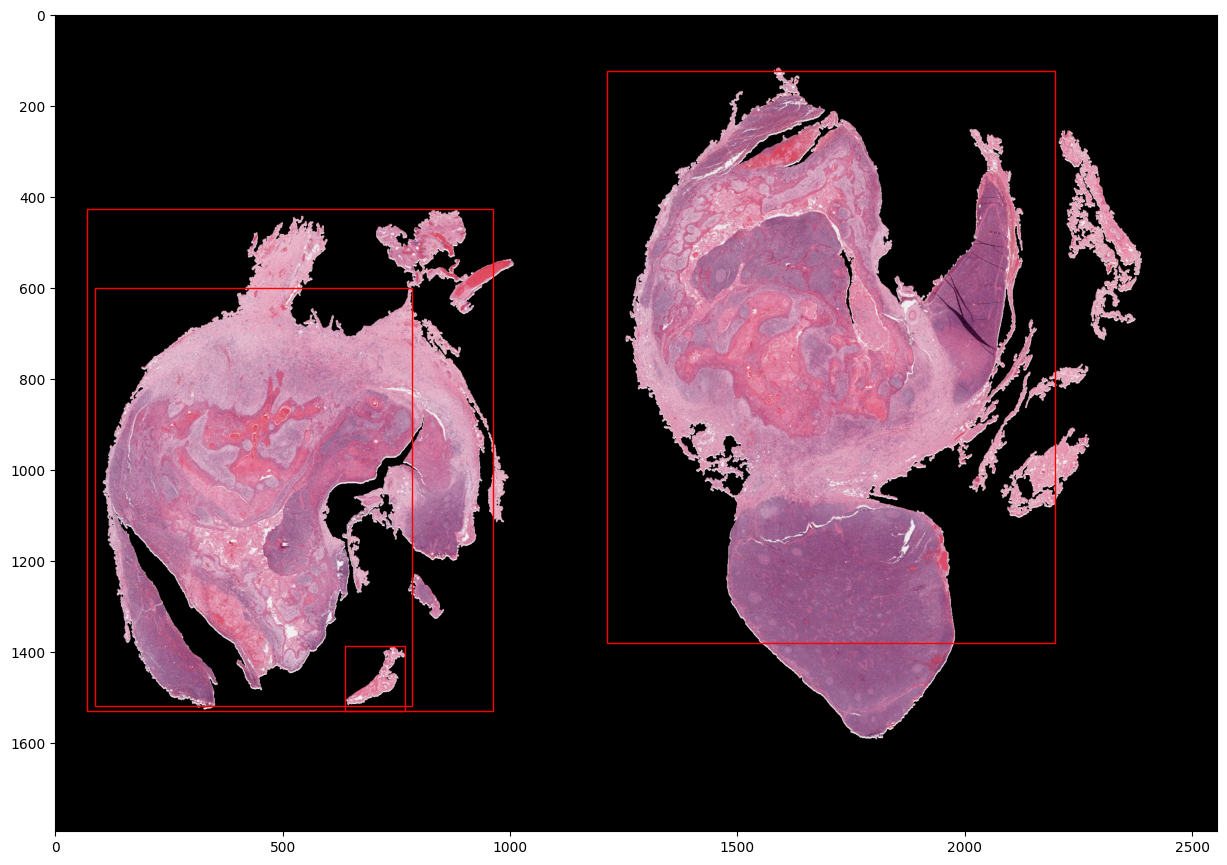

In [29]:
## Visualize
fig, ax = custom_visualizer(img_id, img, instance_dicts, merged_bboxes=False, threshold=0.4)

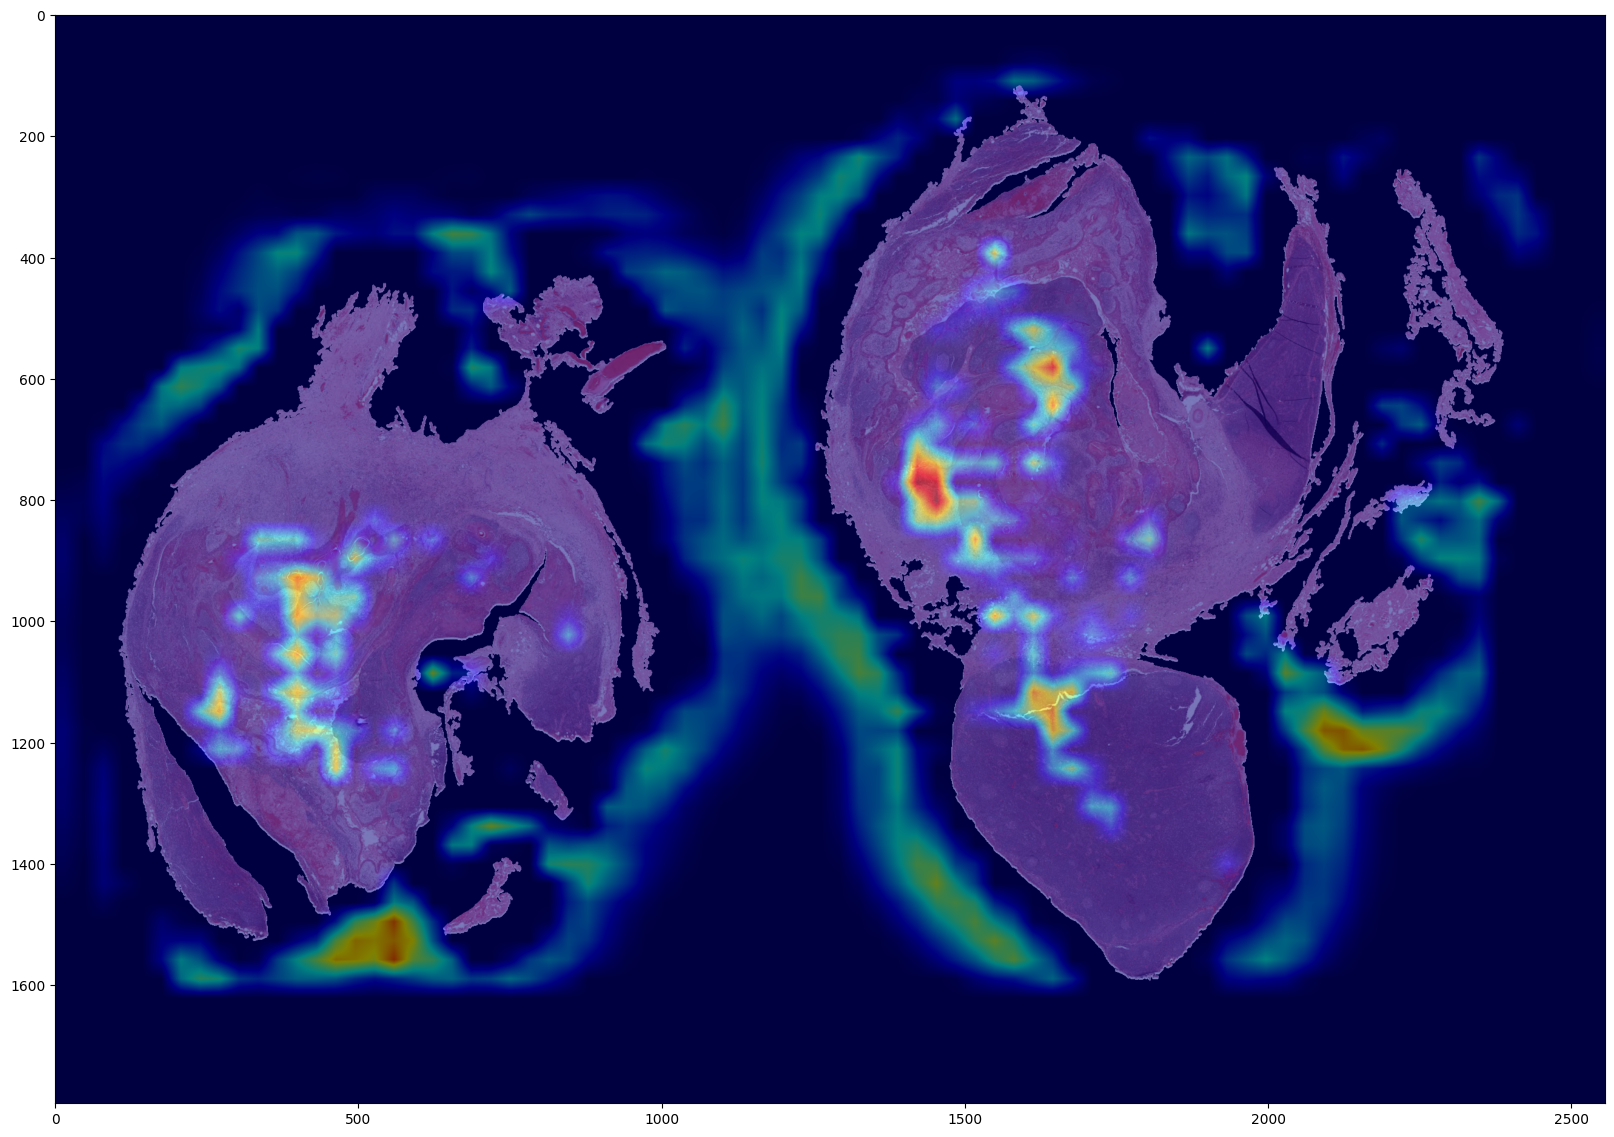

<Figure size 640x480 with 0 Axes>

In [30]:
# Get GradCAM
conv_layers = get_conv_layers(used_model)
target_layers = [conv_layers[-1]]
cam_images = {}

class_cam = GenerateCam(used_model, inputs, img, 0, target_layers)
cam_images = class_cam()
fig, ax = plt.subplots(1, figsize=(20,20))
plt.imshow(cam_images)
plt.show(); plt.close()
plt.savefig('/home/chao_lab/Documents/gradcam_case20.png')

# Mask Predictions

/home/chao_lab/anaconda3/envs/AI_path/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


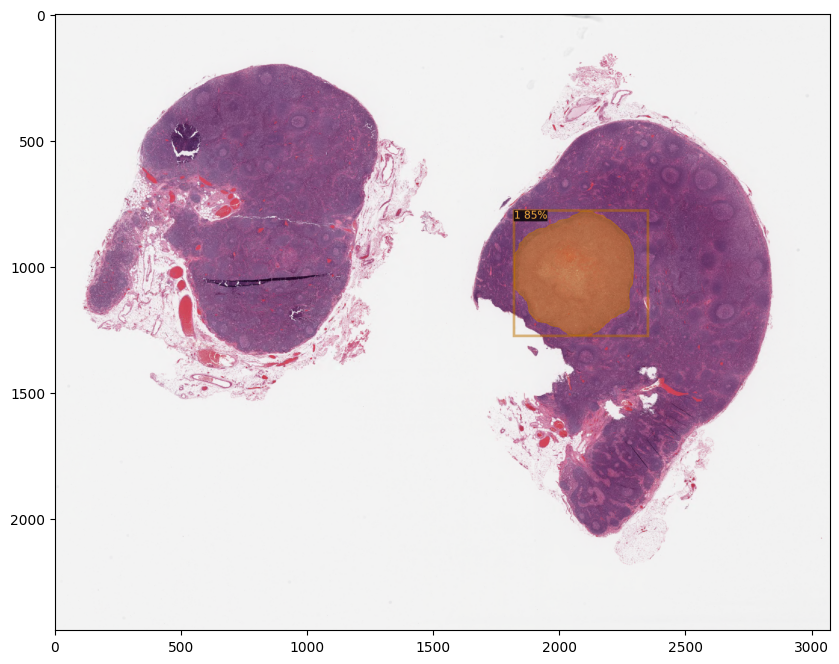

In [6]:
## Visualize with masks

model_path = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/SRI_Mask_with_Pretrain/output/model_final.pth'
config_path = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/SRI_Mask_with_Pretrain/output/config.yaml'
threshold = 0.1

# Create HistomicsTK tissue mask
im_path = '/mnt/RSX/Datasets_pathology/GT_2023/LesionFinderMask/SRI_OSCC_lymph_unlabeled/Case 31 E8.npy'
thumbnail = np.load(im_path)
resized = cv2.resize(thumbnail, (thumbnail.shape[1]//4, thumbnail.shape[0]//4))
blurred = cv2.medianBlur(resized, 5)
labeled, mask = get_tissue_mask(blurred, deconvolve_first=False, n_thresholding_steps=1, sigma=5, min_size=10)
dilated_img = binary_fill_holes(labeled)
dilated_scaled = cv2.resize(dilated_img.astype(np.uint8), (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)
tissue_regions = np.zeros_like(thumbnail)
for j in range(3):
    tissue_regions[:,:,j] = thumbnail[:,:,j] * dilated_scaled

cfg = get_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold



student_model = UBRCNNTeacherTrainer.build_model(cfg)
teacher_model = UBRCNNTeacherTrainer.build_model(cfg)
model = EnsembleTSModel(teacher_model, student_model)
model.eval()
used_model = model.modelStudent

checkpointer = DetectionCheckpointer(model) 
checkpointer.load(cfg.MODEL.WEIGHTS)   

dict = ParseUnlabeled(im_path).get_unlabeled_coco(im_path)
#img = np.load(dict[0]['file_name'])
img = thumbnail
im = torch.from_numpy(img).permute(2, 0, 1)
img_id = dict[0]['file_name'].split('/')[-1].split('.')[0]
inputs = [{"image": im, "height": im.shape[1], "width": im.shape[2]}]


with torch.no_grad():
    outputs = used_model(inputs)

fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(detectron2_visualizer(img, outputs[0]))
plt.show()
#fig.savefig('/home/chao_lab/Documents/mask_case20.png', dpi=800)
plt.close()

# Batch Comparison

In [9]:
def histomics_tk_method(thumbnail, used_model):
    

    # Create HistomicsTK tissue mask
    resized = cv2.resize(thumbnail, (thumbnail.shape[1]//4, thumbnail.shape[0]//4))
    blurred = cv2.medianBlur(resized, 5)
    labeled, mask = get_tissue_mask(blurred, deconvolve_first=False, n_thresholding_steps=1, sigma=5, min_size=10)
    dilated_img = binary_fill_holes(labeled)
    dilated_scaled = cv2.resize(dilated_img.astype(np.uint8), (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)
    tissue_regions = np.zeros_like(thumbnail)
    for j in range(3):
        tissue_regions[:,:,j] = thumbnail[:,:,j] * dilated_scaled
    # Run inference
    dicty = ParseUnlabeled(im_path).get_unlabeled_coco(im_path)
    img = tissue_regions
    im = torch.from_numpy(img).permute(2, 0, 1)
    img_id = dicty[0]['file_name'].split('/')[-1].split('.')[0]
    inputs = [{"image": im, "height": im.shape[1], "width": im.shape[2]}]
    with torch.no_grad():
        outputs = used_model(inputs)
        instances = outputs[0]["instances"].to("cpu")
        instance_dicts = []
        for i in range(len(instances)):
            instance_dicts.append({'category_id': instances[i].pred_classes.numpy()[0], 
                                    'bbox': instances[i].pred_boxes.tensor.numpy()[0].tolist(),
                                    'score': instances[i].scores.numpy()[0]})
        final_anno = instance_dicts
    return final_anno

In [30]:
def tfv1_method(thumbnail, used_model):
    # Generate mask by thresholding and morphological transformations
    kernel = (3, 3)
    gray = cv2.cv2tColor(thumbnail, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, kernel, cv2.BORDER_DEFAULT)
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    morph = cv2.dilate(otsu, kernel, iterations=2)
    morph = cv2.erode(morph, kernel, iterations=2)

    # Fill small holes
    # NOTE: floodfill tends to be unreliable, should skip
    h, w = morph.shape
    floodfill = morph.copy()
    floodfill_mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(floodfill, floodfill_mask, (0, 0), 155)

    # Remove small blobs and get tissue mask
    # 1. Get contours
    contours, hierarchy = cv2.findContours(
                            floodfill,
                            mode=cv2.RETR_TREE,
                            method=cv2.CHAIN_APPROX_SIMPLE)
    # 2. Filter out contours that are too small
    #    i.e., likely not tissue
    cons_to_keep = []
    im_area = floodfill.shape[0] * floodfill.shape[1]
    for c in contours:
        cbox = cv2.boundingRect(c)
        x, y, w, h = cbox
        # Filter out boxes with weird ratios
        long_edge = max(w, h)
        short_edge = min(w, h)
        if long_edge/short_edge > 10:
            continue
        cbox_area = w * h
        if im_area*0.99 > cbox_area > im_area*0.001:
            cons_to_keep.append(c)

    # Convert contours to tissue mask
    final_mask = np.zeros(floodfill.shape, np.uint8)
    for idx in cons_to_keep:    
        cv2.drawContours(
            final_mask,
            cons_to_keep,
            contourIdx=-1,
            color=(255),
            thickness=-1
            )
    final_mask = final_mask/255

    # Use mask to zero out non-tissue regions

    tissue_regions = np.zeros_like(thumbnail)
    for i in range(3):
        tissue_regions[:,:,i] = thumbnail[:,:,i] * final_mask
    # Run Inference
    dicty = ParseUnlabeled(im_path).get_unlabeled_coco(im_path)
    img = tissue_regions
    im = torch.from_numpy(img).permute(2, 0, 1)
    img_id = dicty[0]['file_name'].split('/')[-1].split('.')[0]
    inputs = [{"image": im, "height": im.shape[1], "width": im.shape[2]}]
    with torch.no_grad():
        outputs = used_model(inputs)
        instances = outputs[0]["instances"].to("cpu")
        instance_dicts = []
        for i in range(len(instances)):
            instance_dicts.append({'category_id': instances[i].pred_classes.numpy()[0], 
                                    'bbox': instances[i].pred_boxes.tensor.numpy()[0].tolist(),
                                    'score': instances[i].scores.numpy()[0]})
        final_anno = instance_dicts
        #merged = merge_bboxes(final_anno, 0.5)
        
    return final_anno

In [31]:
def comparison(npy_dir, out_dir):
    model_path = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/TissueFinderV2.2/model_final.pth'
    config_path = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/completed_outputs/TissueFinderV2.2/config.yaml'
    threshold = 0.5

    cfg = get_cfg()
    cfg.set_new_allowed(True)
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = model_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold

    student_model = UBRCNNTeacherTrainer.build_model(cfg)
    teacher_model = UBRCNNTeacherTrainer.build_model(cfg)
    model = EnsembleTSModel(teacher_model, student_model)
    model.eval()
    used_model = model.modelStudent

    checkpointer = DetectionCheckpointer(model) 
    checkpointer.load(cfg.MODEL.WEIGHTS)   
    
    if not os.path.exists(os.path.join(out_dir, 'visualizations')):
        os.makedirs(os.path.join(out_dir, 'visualizations'))
    for i in glob.glob(npy_dir + '*.npy'):
        img_name = os.path.basename(i)
        vis_name = img_name.split('.')[0] + '.png'
        thumbnail = np.load(i)
        
        annos1 = histomics_tk_method(thumbnail, used_model=used_model)
        annos2 = tfv1_method(thumbnail, used_model=used_model)
        
        fig, ax = comparison_visualizer(thumbnail, annos1, annos2, threshold=0.5)
        try:
            ax.legend(['HistomicsTK', 'TissueFinderV1'])
            # Set legend colors
            leg = ax.get_legend()
            leg.legend_handles[0].set_color('y')
            leg.legend_handles[1].set_color('b')
        except:
            pass
        plt.savefig(os.path.join(out_dir, vis_name))
        plt.close()
    

In [12]:
in_dir = '/mnt/RSX/Datasets_pathology/GT_2023/LesionsSet3Labeled/'
out_dir = '/mnt/RSX/Datasets_pathology/GT_2023/LesionsSet3Labeled/Comparison/'


comparison(in_dir, out_dir)

/home/chao_lab/anaconda3/envs/AI_path/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Save GTs

In [4]:
def htk_preprocessing(img):
    resized = cv2.resize(thumbnail, (thumbnail.shape[1]//4, thumbnail.shape[0]//4))
    blurred = cv2.medianBlur(resized, 5)
    labeled, mask = get_tissue_mask(blurred, deconvolve_first=False, n_thresholding_steps=1, sigma=5, min_size=10)
    dilated_img = binary_fill_holes(labeled)
    dilated_scaled = cv2.resize(dilated_img.astype(np.uint8), (thumbnail.shape[1], thumbnail.shape[0]), interpolation=cv2.INTER_NEAREST)

    tissue_regions = np.zeros_like(img)
    for i in range(3):
        tissue_regions[:,:,i] = img[:,:,i] * final_mask
    
    return tissue_regions, final_mask

In [5]:
def floodfill_preprocessing(img):
    # Generate mask by thresholding and morphological transformations
    kernel = (3, 3)
    normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    gray = cv2.cvtColor(normalized, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, kernel, cv2.BORDER_DEFAULT)
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    morph = cv2.dilate(otsu, kernel, iterations=2)
    morph = cv2.erode(morph, kernel, iterations=2)

    # Fill small holes
    h, w = morph.shape
    floodfill = morph.copy()
    floodfill_mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(floodfill, floodfill_mask, (0, 0), 155)
    
    # Resize mask to original image size
    final_mask = cv2.resize(floodfill_mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    # Invert mask to use as filter
    final_mask = np.abs(1 - final_mask)
    # Apply mask to image
    tissue_regions = np.zeros_like(img)
    for i in range(3):
        tissue_regions[:,:,i] = img[:,:,i] * final_mask
    return tissue_regions, final_mask

In [17]:
# save preprocessed to disk

in_dir = '/mnt/RSX/Datasets_pathology/GT_2023/TFV2/SRI_OSCC_lymph_labeled'
out_dir = '/mnt/RSX/Datasets_pathology/GT_2023/TFV3/SRI_OSCC_lymph_labeled'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
for img_path in glob.glob(in_dir + '/*.npy'):
    img = np.load(img_path)
    img_name = os.path.basename(img_path)
    img_noext = img_name.split('.')[0]
    tissue_regions, final_mask = floodfill_preprocessing(img)
    img_dict = []
    # convert to polygon
    contours, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # for each contour, create a mask annotation
    for contour in contours:
        # get bbox
        x1, y1, w, h = cv2.boundingRect(contour)
        x2, y2 = x1 + w, y1 + h
        coords = []
        for point in contour:
            coords.append(point[0].astype(int))
        # cv2 contours aren't closed, so we close them
        coords.append(contour[0][0].astype(int))
        coords = np.array(coords)
        coords = coords.flatten()
        new_coords = []
        for j in coords:
            new_coords.append(j)
        # for each object, a dict is required
        each_dict = {"category_id": 0, # idk how to fix this
                    "bbox": [x1, y1, x2, y2], 
                    "bbox_mode": 0, # bbox mode xywh
                    "segmentation": [new_coords]} # segmentation for mask head
        img_dict.append(each_dict)
    # for each image, a dict containing all object dicts is required
    total_dict = {"file_name": img_path,
                  "image_id": img_noext,
                  "height": img.shape[0],
                  "width": img.shape[1],
                  "annotations": img_dict} # all objects in the image
    with open(os.path.join(out_dir, 'annotations.json'), 'w') as f:
        json.dump(total_dict, f, indent = 4, cls=NpEncoder)
    np.save(os.path.join(out_dir, img_name), tissue_regions)

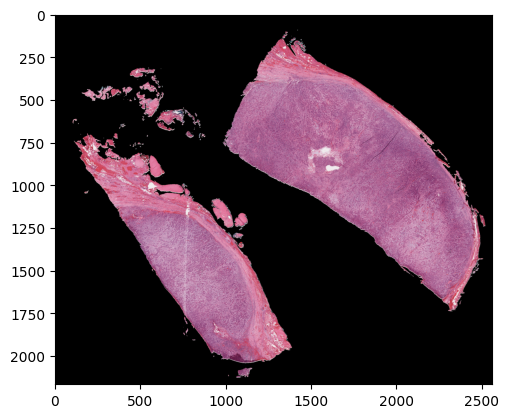

In [10]:
sample = np.load("/mnt/RSX/Datasets_pathology/GT_2023/TFV3/SRI_OSCC_lymph_labeled/Case 1 G7.npy")
plt.imshow(sample)

# Inference + DICE

In [ ]:
# Inference + DICE

model_path = ''
config_path = ''
cfg = get_cfg()
cfg.set_new_allowed(True)
cfg.merge_from_file(config_path)
cfg.MODEL.WEIGHTS = model_path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

student_model = UBRCNNTeacherTrainer.build_model(cfg)
teacher_model = UBRCNNTeacherTrainer.build_model(cfg)
model = EnsembleTSModel(teacher_model, student_model)
model.eval()
used_model = model.modelStudent # we only use the student model since it is fully supervised

checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

def get_unlabeled(img_file):

    """
    Get unlabeled image dict for detectron2
    """
    f = np.load(img_file)
    shape = f.shape
    del f # use del instead of with because numpy version issue
    img_base = os.path.basename(os.path.splitext(img_file)[0])
    ## Fill remaining fields
    dataset_dicts = [{'file_name': img_file,
                    'height': shape[0],
                    'width': shape[1],
                    'image_id': img_base}
                    ]
    return dataset_dicts

def detectron2_visualizer(img, outputs):
    """
    Create visualizations of our model outputs
    """
    v = Visualizer(img[:, :, ::-1], scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return v.get_image()[:, :, ::-1]

def main(img_file, model):
# Single-image inference script
    dicts = get_unlabeled(img_file) # create dictionary for registration
    #print(dicts)
    fname = dicts[0]['file_name']
    #print(f"Processing {fname}")
    f_id = fname.split('/')[-1].split('.')[0]

    mask_dir = os.path.join(train_dir, f_id, 'masks')
    final_gt = np.zeros_like(np.load(fname)[:,:,0])
    for mask in os.listdir(mask_dir):
        mask_path = os.path.join(mask_dir, mask)
        mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_img = mask_img / 255
        mask_img = mask_img.astype(np.uint8)
        final_gt += mask_img

    img = np.load(dicts[0]['file_name'])
    im = torch.from_numpy(img).permute(2, 0, 1) # convert to torch tensor
    inputs = [{"image": im, "height": im.shape[1], "width": im.shape[2]}]
    with torch.no_grad():
        outputs = used_model(inputs)
        instances = outputs[0]["instances"].to("cpu")
        final_pred = np.zeros_like(img[:,:,0])
        for i in range(len(instances)):
            pred = instances[i].pred_masks.numpy()[0].tolist()
            final_pred += pred
            
        def dice_score(gt, pred):
            intersection = np.sum(gt * pred)
            union = np.sum(gt) + np.sum(pred)
            dice = 2 * intersection / union
            return dice

    dice_score = dice_score(final_gt, final_pred)
    
    # visualize our outputs
    #fig, ax = plt.subplots(2, figsize=(20, 20))
    #ax[0].imshow(img)
    #ax[1].imshow(detectron2_visualizer(img, outputs[0]))

    #plt.show()
    #fig.savefig(os.path.join(out_path, f_id + '.png'), dpi=800)
    #plt.close()
    
    return dice_score

In [234]:
each_ds = []
for i in glob.glob(''):
    each_ds.append(main(i, used_model))
final_ds = np.mean(each_ds)
print(final_ds)

0.799813809161384
